# Korean MRC Baseline

## Dependency
다음과 같은 라이브러리를 사용한다.
- [Konlpy](https://konlpy.org/ko/latest/index.html): 파이썬 한국어 NLP 처리기
- [Mecab-korean](https://bitbucket.org/eunjeon/mecab-ko-dic/src): 한국어 형태소 분석기

In [ ]:
! apt-get install -y openjdk-8-jdk python3-dev
! pip install konlpy "tweepy<4.0.0"
! /bin/bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-dev is already the newest version (3.6.7-1~18.04).
python3-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libxxf86dga1 openjdk-8-jdk-headless openjdk-8-jre
  openjdk-8-jre-headless x11-utils
Suggested packages:
  gvfs openjdk-8-demo openjdk-8-source visualvm icedtea-8-plugin libnss-mdns
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libgail-common libgail18 libgtk2.0-0 libgtk2.

## 데이터셋 구성
현재 JSON 데이터를 볼 수 있는 클래스를 하나 작성하자.

In [ ]:
from typing import List, Tuple, Dict, Any
import json
import random

class KoMRC:
    def __init__(self, data, indices: List[Tuple[int, int, int]]):
        self._data = data
        self._indices = indices

    # Json을 불러오는 메소드
    @classmethod
    def load(cls, file_path: str):
        with open(file_path, 'r', encoding='utf-8') as fd:
            data = json.load(fd)

        indices = []
        for d_id, document in enumerate(data['data']):
            for p_id, paragraph in enumerate(document['paragraphs']):
                for q_id, _ in enumerate(paragraph['qas']):
                    indices.append((d_id, p_id, q_id))
        
        return cls(data, indices)

    # 데이터 셋을 잘라내는 메소드
    @classmethod
    def split(cls, dataset, eval_ratio: float=.1, seed=42):
        indices = list(dataset._indices)
        random.seed(seed)
        random.shuffle(indices)
        train_indices = indices[int(len(indices) * eval_ratio):]
        eval_indices = indices[:int(len(indices) * eval_ratio)]

        return cls(dataset._data, train_indices), cls(dataset._data, eval_indices)

    def __getitem__(self, index: int) -> Dict[str, Any]:
        d_id, p_id, q_id = self._indices[index]
        paragraph = self._data['data'][d_id]['paragraphs'][p_id]

        context = paragraph['context']
        qa = paragraph['qas'][q_id]

        guid = qa['guid']
        question = qa['question']
        answers = qa['answers']

        return {
            'guid': guid,
            'context': context,
            'question': question,
            'answers': answers
        }

    def __len__(self) -> int:
        return len(self._indices)


`load` 메소드를 이용해서 Json 데이터를 불러올 수 있다.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train.json to train.json


In [ ]:
dataset = KoMRC.load('./train.json')
print("Number of Samples:", len(dataset))
print(dataset[0])

Number of Samples: 12037
{'guid': '798db07f0b9046759deed9d4a35ce31e', 'context': '올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도 늦은 이달 말께 장마가 시작될 전망이다.17일 기상청에 따르면 제주도 남쪽 먼바다에 있는 장마전선의 영향으로 이날 제주도 산간 및 내륙지역에 호우주의보가 내려지면서 곳곳에 100㎜에 육박하는 많은 비가 내렸다. 제주의 장마는 평년보다 2~3일, 지난해보다는 하루 일찍 시작됐다. 장마는 고온다습한 북태평양 기단과 한랭 습윤한 오호츠크해 기단이 만나 형성되는 장마전선에서 내리는 비를 뜻한다.장마전선은 18일 제주도 먼 남쪽 해상으로 내려갔다가 20일께 다시 북상해 전남 남해안까지 영향을 줄 것으로 보인다. 이에 따라 20~21일 남부지방에도 예년보다 사흘 정도 장마가 일찍 찾아올 전망이다. 그러나 장마전선을 밀어올리는 북태평양 고기압 세력이 약해 서울 등 중부지방은 평년보다 사나흘가량 늦은 이달 말부터 장마가 시작될 것이라는 게 기상청의 설명이다. 장마전선은 이후 한 달가량 한반도 중남부를 오르내리며 곳곳에 비를 뿌릴 전망이다. 최근 30년간 평균치에 따르면 중부지방의 장마 시작일은 6월24~25일이었으며 장마기간은 32일, 강수일수는 17.2일이었다.기상청은 올해 장마기간의 평균 강수량이 350~400㎜로 평년과 비슷하거나 적을 것으로 내다봤다. 브라질 월드컵 한국과 러시아의 경기가 열리는 18일 오전 서울은 대체로 구름이 많이 끼지만 비는 오지 않을 것으로 예상돼 거리 응원에는 지장이 없을 전망이다.', 'question': '북태평양 기단과 오호츠크해 기단이 만나 국내에 머무르는 기간은?', 'answers': [{'text': '한 달가량', 'answer_start': 478}, {'text': '한 달', 'answer_start': 478}]}


`split` 메소드를 이용하면 데이터 셋을 나눌 수 있다.

In [ ]:
train_dataset, dev_dataset = KoMRC.split(dataset)
print("Number of Train Samples:", len(train_dataset))
print("Number of Dev Samples:", len(dev_dataset))
print(dev_dataset[0])

Number of Train Samples: 10834
Number of Dev Samples: 1203
{'guid': '844e22ab28924c1697d5ac28801b34c1', 'context': '지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다. 대한민국연극대상 연기·무대예술상, 동아연극상 작품·희곡·연기상 등을 수상한 ‘알리바이 연대기’(17~20일 대학로 아르코예술극장 대극장, 25일~5월11일 서계동 국립극단 백성희장민호극장), 연극대상에서 대상과 희곡상을 받은 ‘여기가 집이다’(18일~5월22일 대학로 연우소극장), 연극대상 작품·연출상과 김상열연극상 수상작인 ‘황금용’(5월9~18일 서강대 메리홀 대극장)이다. 초연 당시 짧은 상연 기간과 낮은 인지도 등으로 공연을 놓친 연극팬에겐 평단으로부터 작품성을 인정받은 수작을 관람할 수 있는 기회다. ‘알리바이 연대기’는 희곡을 쓰고 연출한 김재엽의 가족사에 근거한 다큐멘터리 드라마다. 1930년에 태어난 한 개인의 사적인 연대기를 바탕으로 그 사이를 파고드는 역사적 순간들을 정밀하게 조명한다. 연출가는 “공적인 권력이 사적인 권리를 지켜주기보다 억압하기 일쑤였던 한국 현대사 속에서 개인은 언제나 무죄를 입증하며 하루하루 자신을 지켜내야 하는 ‘알리바이의 연대기’ 속에서 살아왔다”고 말한다.한국연극평론가협회는 이 작품을 ‘2013년 올해의 연극 베스트3’로 선정하며 “촘촘하고 세세하게 삶에 천착해 개인과 역사에 대한 이분법적 관점을 극복한다. 정치극에 대한 새로운 가능성을 보여줬다”고 평했다. 이 작품으로 연기상을 휩쓴 남명렬을 비롯해 지춘성 정원조 등 초연 배우들이 그대로 출연한다.‘여기가 집이다’는 허름하고 볼품 없는 ‘20년 전통’의 고시원에 모여 사는 사람들의 절망과 희망을 그린 작품. ‘차력사와 아코디언’ ‘택배 왔어요’를 만든 극단 이와삼의 장우재 대표가 직접 대본을 쓰고 연출했다. 나름의 규칙을 가지고 평화로웠던 고시원에 새로운 주인으로 등장한 ‘2

단어 단위로 토큰화해서 정답 위치를 찾기 위하여 토큰화 및 위치 인덱싱을 하는 클래스를 상속을 통해 작성해 보자.

In [ ]:
from typing import Generator

import konlpy

class TokenizedKoMRC(KoMRC):
    def __init__(self, data, indices: List[Tuple[int, int, int]]) -> None:
        super().__init__(data, indices)
        self._tagger = konlpy.tag.Mecab()

    def _tokenize_with_position(self, sentence: str) -> List[Tuple[str, Tuple[int, int]]]:
        position = 0
        tokens = []
        for morph in self._tagger.morphs(sentence):
            position = sentence.find(morph, position)
            tokens.append((morph, (position, position + len(morph))))
            position += len(morph)
        return tokens
            
    def __getitem__(self, index: int) -> Dict[str, Any]:
        sample = super().__getitem__(index)

        context, position = zip(*self._tokenize_with_position(sample['context']))
        context, position = list(context), list(position)
        question = self._tagger.morphs(sample['question'])

        if sample['answers'] is not None:
            answers = []
            for answer in sample['answers']:
                for start, (position_start, position_end) in enumerate(position):
                    if position_start <= answer['answer_start'] < position_end:
                        break
                else:
                    print(context, answer)
                    raise ValueError("No mathced start position")

                target = ''.join(answer['text'].split(' '))
                source = ''
                for end, morph in enumerate(context[start:], start):
                    source += morph
                    if target in source:
                        break
                else:
                    print(context, answer)
                    raise ValueError("No Matched end position")

                answers.append({
                    'start': start,
                    'end': end
                })
        else:
            answers = None
        
        return {
            'guid': sample['guid'],
            'context_original': sample['context'],
            'context_position': position,
            'question_original': sample['question'],
            'context': context,
            'question': question,
            'answers': answers
        }
        

In [ ]:
dataset = TokenizedKoMRC.load('./train.json')

train_dataset, dev_dataset = TokenizedKoMRC.split(dataset)
print("Number of Train Samples:", len(train_dataset))
print("Number of Dev Samples:", len(dev_dataset))
print(dev_dataset[0])

Number of Train Samples: 10834
Number of Dev Samples: 1203
{'guid': '844e22ab28924c1697d5ac28801b34c1', 'context_original': '지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다. 대한민국연극대상 연기·무대예술상, 동아연극상 작품·희곡·연기상 등을 수상한 ‘알리바이 연대기’(17~20일 대학로 아르코예술극장 대극장, 25일~5월11일 서계동 국립극단 백성희장민호극장), 연극대상에서 대상과 희곡상을 받은 ‘여기가 집이다’(18일~5월22일 대학로 연우소극장), 연극대상 작품·연출상과 김상열연극상 수상작인 ‘황금용’(5월9~18일 서강대 메리홀 대극장)이다. 초연 당시 짧은 상연 기간과 낮은 인지도 등으로 공연을 놓친 연극팬에겐 평단으로부터 작품성을 인정받은 수작을 관람할 수 있는 기회다. ‘알리바이 연대기’는 희곡을 쓰고 연출한 김재엽의 가족사에 근거한 다큐멘터리 드라마다. 1930년에 태어난 한 개인의 사적인 연대기를 바탕으로 그 사이를 파고드는 역사적 순간들을 정밀하게 조명한다. 연출가는 “공적인 권력이 사적인 권리를 지켜주기보다 억압하기 일쑤였던 한국 현대사 속에서 개인은 언제나 무죄를 입증하며 하루하루 자신을 지켜내야 하는 ‘알리바이의 연대기’ 속에서 살아왔다”고 말한다.한국연극평론가협회는 이 작품을 ‘2013년 올해의 연극 베스트3’로 선정하며 “촘촘하고 세세하게 삶에 천착해 개인과 역사에 대한 이분법적 관점을 극복한다. 정치극에 대한 새로운 가능성을 보여줬다”고 평했다. 이 작품으로 연기상을 휩쓴 남명렬을 비롯해 지춘성 정원조 등 초연 배우들이 그대로 출연한다.‘여기가 집이다’는 허름하고 볼품 없는 ‘20년 전통’의 고시원에 모여 사는 사람들의 절망과 희망을 그린 작품. ‘차력사와 아코디언’ ‘택배 왔어요’를 만든 극단 이와삼의 장우재 대표가 직접 대본을 쓰고 연출했다. 나름의 규칙을 가지고 평화로웠던 고시원에 새로운 주인

In [ ]:
sample = dev_dataset[0]
print(sample['context'][sample['answers'][0]['start']:sample['answers'][0]['end']+1])

['서강대', '메리', '홀', '대극장']


## Vocab 생성 및 Indexing
토큰화된 데이터 셋을 기준으로 Vocab을 만들고 인덱싱을 하는 `Indexer`를 만들자.

In [ ]:
import os.path as p
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('axes', labelsize=15)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=15)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=15)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=15)  # 범례 폰트 크기

In [ ]:
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

In [ ]:
from typing import Sequence
from collections import Counter
from itertools import chain

from tqdm.notebook import tqdm

class Indexer:
    def __init__(self,
        id2token: List[str], 
        max_length: int=1024,
        pad: str='<pad>', unk: str='<unk>', cls: str='<cls>', sep: str='<sep>'
    ):
        self.pad = pad
        self.unk = unk
        self.cls = cls
        self.sep = sep
        self.special_tokens = [pad, unk, cls, sep]

        self.max_length = max_length

        self.id2token = self.special_tokens + id2token
        self.token2id = {token: token_id for token_id, token in enumerate(self.id2token)}

    @property
    def vocab_size(self):
        return len(self.id2token)
    
    @property
    def pad_id(self):
        return self.token2id[self.pad]
    @property
    def unk_id(self):
        return self.token2id[self.unk]
    @property
    def cls_id(self):
        return self.token2id[self.cls]
    @property
    def sep_id(self):
        return self.token2id[self.sep]

    @classmethod
    def build_vocab(cls,
        dataset: TokenizedKoMRC, 
        min_freq: int=5
    ):
        counter = Counter(chain.from_iterable(
            sample['context'] + sample['question']
            for sample in tqdm(dataset, desc="Counting Vocab")
        ))

        return cls([word for word, count in counter.items() if count >= min_freq])
    
    def decode(self,
        token_ids: Sequence[int]
    ):
        return [self.id2token[token_id] for token_id in token_ids]

    def sample2ids(self,
        sample: Dict[str, Any],
    ) -> Dict[str, Any]:
        context = [self.token2id.get(token, self.unk_id) for token in sample['context']]
        question = [self.token2id.get(token, self.unk_id) for token in sample['question']]

        #context = context[:self.max_length-len(question)-3]             # Truncate context
        
        input_ids = [self.cls_id] + question + [self.sep_id] + context + [self.sep_id]
        token_type_ids = [0] * (len(question) + 1) + [1] * (len(context) + 2)

        if sample['answers'] is not None:
            answer = sample['answers'][0]
            start = min(answer['start'] + len(question) + 2, self.max_length - 1)
            end = min(answer['end'] + len(question) + 2, self.max_length - 1)
        else:
            start = None
            end = None

        return {
            'guid': sample['guid'],
            'context': sample['context_original'],
            'question': sample['question_original'],
            'position': sample['context_position'],
            'input_ids': input_ids,
            'token_type_ids': token_type_ids,
            'start': start,
            'end': end
        }

In [ ]:
indexer = Indexer.build_vocab(dataset)
print(indexer.sample2ids(dev_dataset[0]))

Counting Vocab:   0%|          | 0/12037 [00:00<?, ?it/s]

{'guid': '844e22ab28924c1697d5ac28801b34c1', 'context': '지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다. 대한민국연극대상 연기·무대예술상, 동아연극상 작품·희곡·연기상 등을 수상한 ‘알리바이 연대기’(17~20일 대학로 아르코예술극장 대극장, 25일~5월11일 서계동 국립극단 백성희장민호극장), 연극대상에서 대상과 희곡상을 받은 ‘여기가 집이다’(18일~5월22일 대학로 연우소극장), 연극대상 작품·연출상과 김상열연극상 수상작인 ‘황금용’(5월9~18일 서강대 메리홀 대극장)이다. 초연 당시 짧은 상연 기간과 낮은 인지도 등으로 공연을 놓친 연극팬에겐 평단으로부터 작품성을 인정받은 수작을 관람할 수 있는 기회다. ‘알리바이 연대기’는 희곡을 쓰고 연출한 김재엽의 가족사에 근거한 다큐멘터리 드라마다. 1930년에 태어난 한 개인의 사적인 연대기를 바탕으로 그 사이를 파고드는 역사적 순간들을 정밀하게 조명한다. 연출가는 “공적인 권력이 사적인 권리를 지켜주기보다 억압하기 일쑤였던 한국 현대사 속에서 개인은 언제나 무죄를 입증하며 하루하루 자신을 지켜내야 하는 ‘알리바이의 연대기’ 속에서 살아왔다”고 말한다.한국연극평론가협회는 이 작품을 ‘2013년 올해의 연극 베스트3’로 선정하며 “촘촘하고 세세하게 삶에 천착해 개인과 역사에 대한 이분법적 관점을 극복한다. 정치극에 대한 새로운 가능성을 보여줬다”고 평했다. 이 작품으로 연기상을 휩쓴 남명렬을 비롯해 지춘성 정원조 등 초연 배우들이 그대로 출연한다.‘여기가 집이다’는 허름하고 볼품 없는 ‘20년 전통’의 고시원에 모여 사는 사람들의 절망과 희망을 그린 작품. ‘차력사와 아코디언’ ‘택배 왔어요’를 만든 극단 이와삼의 장우재 대표가 직접 대본을 쓰고 연출했다. 나름의 규칙을 가지고 평화로웠던 고시원에 새로운 주인으로 등장한 ‘20세 고등학생’ 동교가 “이제부터 고시원 식구들에게 월세를 받지 않겠다”고 선언하면서 갑작스런 변화의 바람

쉽게 Indexer를 활용하기 위해 Indexer가 포함된 데이터 셋을 만들자.

In [ ]:
class IndexerWrappedDataset:
    def __init__(self, dataset: TokenizedKoMRC, indexer: Indexer) -> None:
        self._dataset = dataset
        self._indexer = indexer

    def __len__(self) -> int:
        return len(self._dataset)
    
    def __getitem__(self, index: int) -> Dict[str, Any]:
        sample = self._indexer.sample2ids(self._dataset[index])
        sample['attention_mask'] = [1] * len(sample['input_ids'])

        return sample


In [ ]:
indexed_train_dataset = IndexerWrappedDataset(train_dataset, indexer)
indexed_dev_dataset = IndexerWrappedDataset(dev_dataset, indexer)

sample = indexed_dev_dataset[0]
print(sample['input_ids'], sample['attention_mask'], sample['token_type_ids'], sample['start'], sample['end'])

[2, 1, 1100, 7, 2226, 71, 4336, 30, 25656, 1139, 97, 57, 39, 2874, 39, 2684, 974, 170, 3, 67, 2912, 4336, 830, 97, 1250, 1278, 553, 1607, 2344, 41, 2239, 30, 4, 3276, 32, 6946, 25656, 4344, 82, 2339, 1386, 15, 1016, 4336, 257, 4355, 695, 4344, 4335, 830, 66, 2412, 4336, 830, 2239, 695, 2386, 695, 4355, 830, 17, 97, 834, 71, 183, 36128, 12542, 588, 8, 64, 90, 9, 276, 142, 1, 4335, 4333, 29910, 66, 132, 9, 64, 246, 130, 530, 9, 24315, 19208, 1, 29106, 4333, 175, 66, 4336, 257, 11, 257, 74, 6503, 1, 97, 649, 20, 183, 2830, 7, 635, 30, 14, 588, 85, 9, 64, 246, 130, 1375, 9, 276, 142, 1, 19205, 175, 66, 4336, 257, 2239, 695, 2226, 830, 74, 33837, 4336, 830, 834, 28079, 183, 1, 588, 246, 130, 1513, 64, 85, 9, 6741, 1807, 1011, 29910, 175, 30, 14, 15, 9493, 1293, 2500, 20, 5450, 135, 74, 981, 20, 2426, 17, 43, 1139, 97, 11653, 4336, 2839, 7081, 9478, 2462, 2239, 332, 97, 4133, 20, 17011, 97, 12211, 407, 402, 38, 39, 950, 14, 15, 183, 36128, 12542, 191, 39, 2386, 97, 2286, 243, 2226, 71, 1, 41

### EDA

In [ ]:
ans_starts = []
ans_lens = []
doc_lens = []
doc_types = []


for dataset in train_dataset :
  ans_start = dataset['answers'][0]['start']
  ans_starts.append(ans_start)
  ans_end = dataset['answers'][0]['end']
  ans_lens.append(ans_end - ans_start + 1)
  doc_lens.append(len(dataset['context']))
  doc_types.append('train_dataset')

for dataset in dev_dataset :
  ans_start = dataset['answers'][0]['start']
  ans_starts.append(ans_start)
  ans_end = dataset['answers'][0]['end']
  ans_lens.append(ans_end - ans_start + 1)
  doc_lens.append(len(dataset['context']))
  doc_types.append('dev_dataset')
    
datas = {
    "ans_starts": ans_starts,
    "ans_lens" : ans_lens,
    "doc_lens" : doc_lens,
    "doc_types": doc_types
}

In [ ]:
df = pd.DataFrame(datas)
df.head(30)

,ans_starts,ans_lens,doc_lens,doc_types
0,377,1,781,train_dataset
1,157,2,302,train_dataset
2,9,4,350,train_dataset
3,460,2,520,train_dataset
4,30,2,584,train_dataset
5,62,3,298,train_dataset
6,547,4,738,train_dataset
7,122,3,312,train_dataset
8,14,2,1023,train_dataset
9,331,2,580,train_dataset


In [ ]:
print(min(ans_lens), max(ans_lens))

1 45


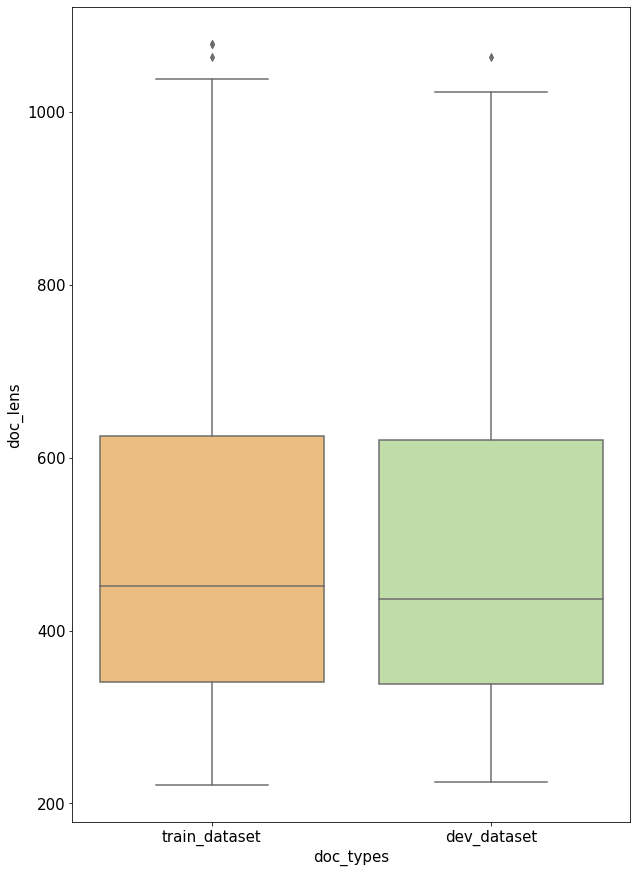

In [ ]:
plt.figure(figsize=(10, 15))
sns.boxplot(x="doc_types", y="doc_lens", data=df, palette = 'Spectral')

ans_starts     84.0
ans_lens        1.0
doc_lens      341.0
Name: 0.25, dtype: float64 
 ans_starts    174.0
ans_lens        2.0
doc_lens      450.0
Name: 0.5, dtype: float64 
 ans_starts    288.0
ans_lens        4.0
doc_lens      625.0
Name: 0.75, dtype: float64


,ans_starts,ans_lens,doc_lens
count,12037.000000,12037.000000,12037.000000
mean,206.140400,2.835092,496.319930
std,160.360551,2.291336,188.851206
min,0.000000,1.000000,221.000000
25%,84.000000,1.000000,341.000000
50%,174.000000,2.000000,450.000000
75%,288.000000,4.000000,625.000000
max,1024.000000,45.000000,1078.000000


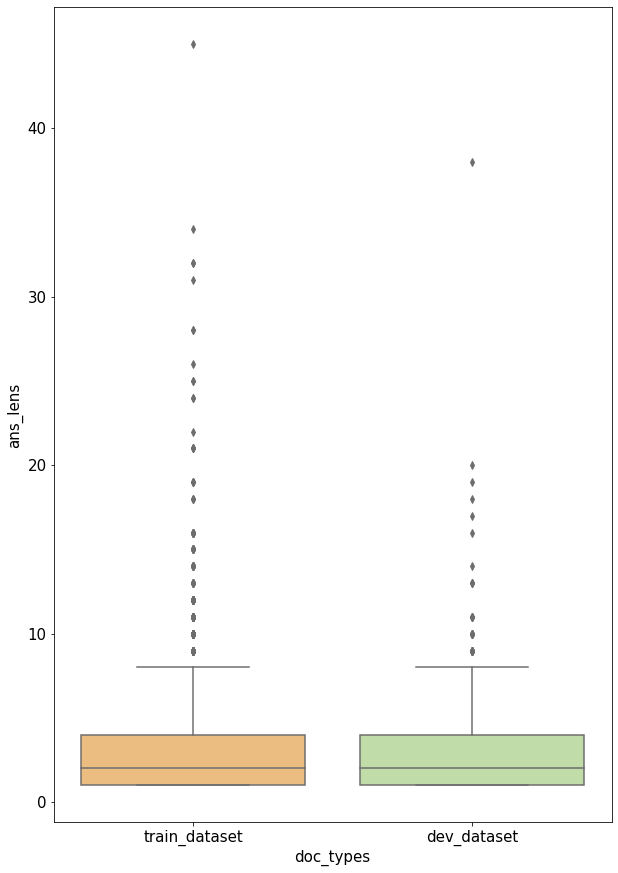

In [ ]:
plt.figure(figsize=(10, 15))
sns.boxplot(x="doc_types", y="ans_lens", data=df, palette = 'Spectral')
q1 = df.quantile(.25)
q2 = df.quantile(.5)
q3 = df.quantile(.75)
print(q1, '\n', q2, '\n', q3)
df.describe()

ans_starts     84.0
ans_lens        1.0
doc_lens      341.0
Name: 0.25, dtype: float64 
 ans_starts    174.0
ans_lens        2.0
doc_lens      450.0
Name: 0.5, dtype: float64 
 ans_starts    288.0
ans_lens        4.0
doc_lens      625.0
Name: 0.75, dtype: float64


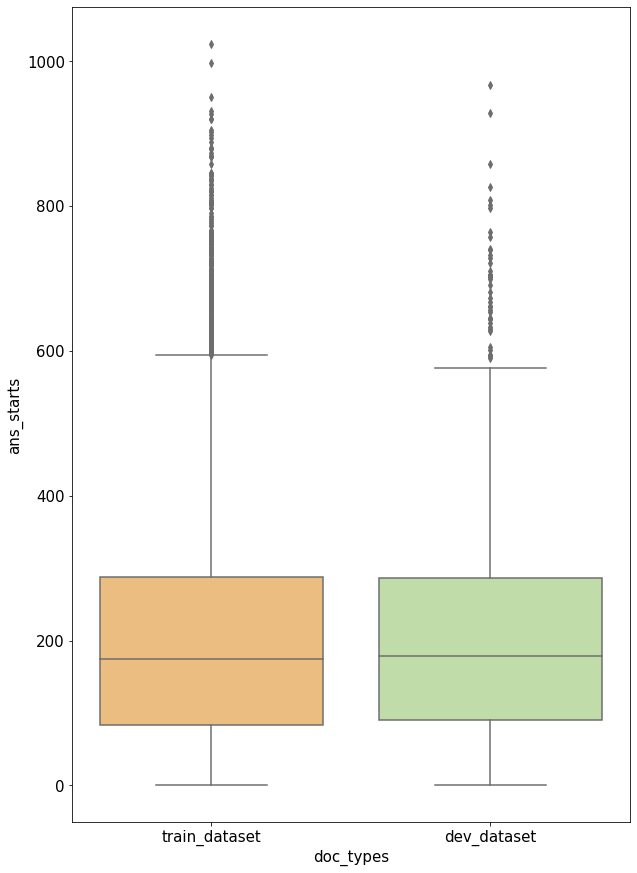

In [ ]:
plt.figure(figsize=(10, 15))
sns.boxplot(x="doc_types", y="ans_starts", data=df, palette = 'Spectral')
q1 = df.quantile(.25)
q2 = df.quantile(.5)
q3 = df.quantile(.75)
print(q1, '\n', q2, '\n', q3)

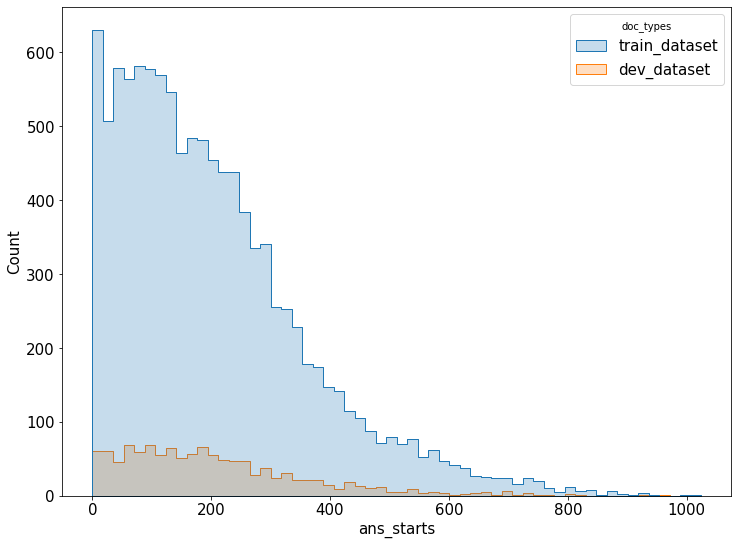

In [ ]:
plt.figure(figsize=(12, 9))
sns.histplot(x="ans_starts", hue="doc_types", element="step",data=df)